In [1]:
"""
Necessary modules
"""
import sys, os
%load_ext autoreload
%autoreload 2 # autoreload to debug/modify modules
import numpy as np
from graphs.my_graph import * # my custom module for ~nice plots
%matplotlib inline

# Wavelet analysis

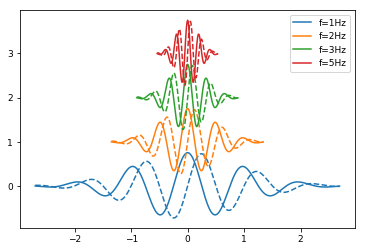

In [77]:
def Morlet_Wavelet(t, f, w0=6.):
    x = 2.*np.pi*f*t
    output = np.exp(1j * x)
    output *= np.exp(-0.5 * ((x/w0) ** 2)) * np.pi ** (-0.25)
    return output

def Morlet_Wavelet_Decay(f, w0=6.):
    return 2 ** .5 * (w0/(np.pi*f))

def from_fourier_to_morlet(freq):
    x = np.linspace(0.1/freq, 2.*freq, 1e3)
    return x[np.argmin((x-freq*(1-np.exp(-freq*x)))**2)]
    
def get_Morlet_of_right_size(f, dt, w0=6., with_t=False):
    Tmax = Morlet_Wavelet_Decay(f, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt))*dt
    if with_t:
        return t, Morlet_Wavelet(t, f, w0=w0)
    else:
        return Morlet_Wavelet(t, f, w0=w0)

for i, f in enumerate([1., 2,  3., 5.]):
    t, wvl = get_Morlet_of_right_size(f, 0.01, with_t=True)
    plt.plot(t, i+np.real(wvl), '-',
             t, i+np.imag(wvl), '--',
             color='C'+str(i), label='f='+str(int(f))+'Hz')
plt.legend()

In [328]:
from scipy import signal
def my_cwt(data, frequencies, dt):
    
    output = np.zeros([len(frequencies), len(data)], dtype=np.complex)

    for ind, freq in enumerate(frequencies):
        wavelet_data = np.conj(get_Morlet_of_right_size(freq, dt))
        # the wavelets have different integrals
        # conv_number compensates for the number of summed points (i.e. also integral of wavelet)
        conv_number = signal.convolve(np.ones(len(data))+0.*1j, np.ones(len(wavelet_data)),
                                      mode='same')
        # the sliding mean that depends on the frequency
        sliding_mean = signal.convolve(data+0.*1j, np.ones(len(wavelet_data)),
                                       mode='same')/conv_number
        # the final convolution
        output[ind, :] = signal.convolve(data-sliding_mean+0.*1j, wavelet_data,
                                         mode='same')/conv_number
    return output
    
def illustration_plot(t, freqs, data, coefs, dt, tstop, freq1, freq2, freq3):
    """
    a plot to illustrate the output of the wavelet analysis
    """
    import matplotlib.pylab as plt
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(wspace=.8, hspace=.5, bottom=.2)
    # signal plot
    plt.subplot2grid((3, 8), (0,0), colspan=6)
    plt.plot(1e3*t, data, 'k-', lw=2)
    plt.ylabel('signal')
    for f, tt in zip([freq2, freq1, freq3], [200,500,800]):
        plt.annotate(str(int(f))+'Hz', (tt, data.max()))
    plt.xlim([1e3*t[0], 1e3*t[-1]])
    # time frequency power plot
    ax1 = plt.subplot2grid((3, 8), (1,0), rowspan=2, colspan=6)
    c = plt.contourf(1e3*t, freqs, coefs, cmap='PRGn')
    plt.xlabel('time (ms)')
    plt.ylabel('frequency (Hz)')
    plt.yticks([10, 40, 70, 100]);
    # inset with legend
    acb = plt.axes([.4, .4, .02, .2])
    plt.colorbar(c, cax=acb, label='coeffs (a.u.)', ticks=[-1, 0, 1])
    # mean power plot over intervals
    plt.subplot2grid((3, 8), (1, 6), rowspan=2)
    for t1, t2 in zip([0,300e-3,700e-3], [300e-3,700e-3, 1000e-3]):
        cond = (t>t1) & (t<t2)
        plt.barh(freqs, np.power(coefs[:,cond],2).mean(axis=1)*dt,\
                 label='t$\in$['+str(int(1e3*t1))+','+str(int(1e3*t2))+']')
    plt.legend(prop={'size':'small'}, loc=(0.1,1.1))
    plt.yticks([10, 40, 70, 100]);
    plt.xticks([]);
    plt.xlabel(' mean \n power \n (a.u.)')
    # max of power over intervals
    plt.subplot2grid((3, 8), (1, 7), rowspan=2)
    for t1, t2 in zip([0,300e-3,600e-3], [300e-3,600e-3, 1000e-3]):
        cond = (t>t1) & (t<t2)
        plt.barh(freqs, np.power(coefs[:,cond],2).max(axis=1)*dt,\
                 label='t$\in$['+str(int(1e3*t1))+','+str(int(1e3*t2))+']')
    plt.yticks([10, 40, 70, 100]);
    plt.xticks([]);
    plt.xlabel(' max. \n power \n (a.u.)');
    return fig

noise_level = 0.0
nfreq = 100

# temporal sampling
dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt

# ### artificially generated signal, transient oscillations
freq1, width1, freq2, width2, freq3, width3 = 10., 100e-3, 40., 40e-3, 70., 20e-3
data  = 3.2+np.cos(2*np.pi*freq1*t)*np.exp(-(t-.5)**2/2./width1**2)+\
        np.cos(2*np.pi*freq2*t)*np.exp(-(t-.2)**2/2./width2**2)+\
        np.cos(2*np.pi*freq3*t)*np.exp(-(t-.8)**2/2./width3**2)

# ### adding colored noise to test robustness
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/400e-3),\
                    np.random.randn(len(t)), mode='same') # a slow one
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/5e-3),\
                    np.random.randn(len(t)), mode='same') # a faster one

# Continuous Wavelet Transform analysis
freqs = np.linspace(1, 100, nfreq)
coefs = my_cwt(data, freqs, dt)

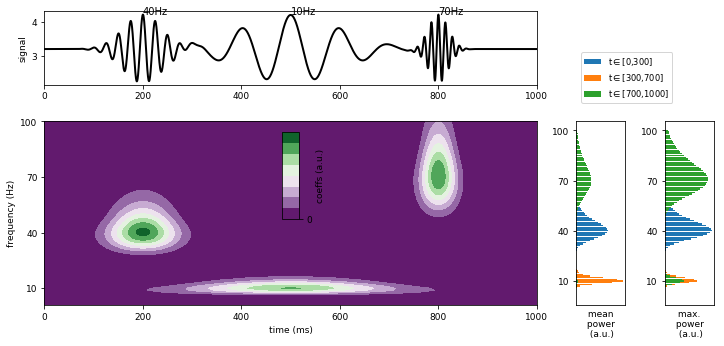

In [329]:
illustration_plot(t, freqs, data, np.abs(coefs), dt, tstop, freq1, freq2, freq3);

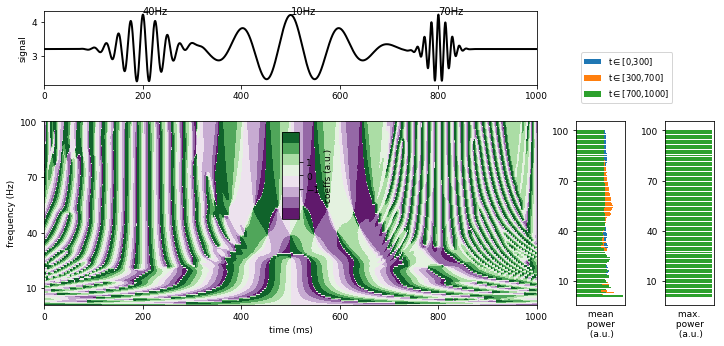

In [491]:
illustration_plot(t, freqs, data, np.angle(coefs), dt, tstop, freq1, freq2, freq3);

# Application to electrophysiological recordings

In [218]:
"""
Loading a sample datafile for the awake
"""
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/'+\
                 'sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
cond = (data[0]>50) & (data[0]<150)
data_awake={'t':data[0][cond], 'Vm':data[1][1][cond], 'Extra':data[1][0][cond]}
data_awake['dt'] = data_awake['t'][1]-data_awake['t'][0]

In [212]:
"""
Loading a sample datafile for the anesthetized
"""
from data_analysis.IO.load_data import load_file
data = load_file(home+'DATA/Data_Ste_Zucca/2017_04_04/14_40_12_CCLAMP-WITH-CORTEX-EXTRA.h5')
cond = (data['t']>300) & (data['t']<400)
data_anesth={'t':data['t'][cond], 'Vm':data['Vm'][cond], 'Extra':data['ExtraCort'][cond]}
data_anesth['dt'] = data_anesth['t'][1]-data_anesth['t'][0]

In [302]:
def preprocess_LFP(data,
                   freqs = np.linspace(50, 300, 5),
                   new_dt = 5e-3, smoothing=20e-3):
    """
    performs continuous wavelet transform
    """
    data['W'] = my_cwt(data['Extra'], freqs, data['dt'])
    data['pLFP_freqs'] = freqs
    W2 = np.abs(data['W']).mean(axis=0)
    isubsmpl = int(new_dt/data['dt'])
    data['pLFP'] = gaussian_smoothing(\
                                      np.reshape(W2[:int(len(W2)/isubsmpl)*isubsmpl],
                                                 (int(len(W2)/isubsmpl),isubsmpl)).mean(axis=1),
                                      int(smoothing/new_dt))
    data['new_t'] = np.arange(len(data['hGamma_Act']))*new_dt+data['t'][0]
    data['new_dt'] = new_dt
    
preprocess_LFP(data_anesth)
preprocess_LFP(data_awake)        

In [291]:
def plot_three_quant(data, tstart=-np.inf, tend=np.inf):
    cond = (data['t']>tstart) & (data['t']<tend)
    fig, AX = figure(axes=(3,1),A0_ratio=(1.6,.4), hspace=.01)
    plot(data['t'][cond], data['Extra'][cond], ax=AX[0][0],
         axes_args={'ylabel':'$V_{ext}$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    plot(data['t'][cond], data['Vm'][cond], ax=AX[1][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'$V_m$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    cond = (data['new_t']>tstart) & (data['new_t']<tend)
    plot(data['new_t'][cond], data['pLFP'][cond], ax=AX[2][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'pLFP (a.u.)',
                    'xlim':[data['new_t'][cond][0], data['new_t'][cond][-1]]}, color=Red);

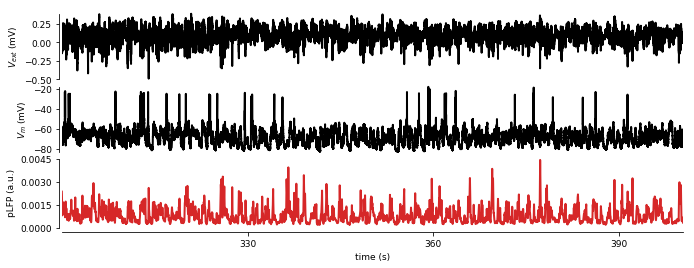

In [292]:
plot_three_quant(data_anesth)

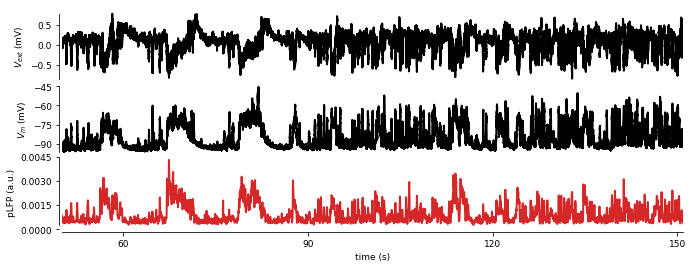

In [293]:
plot_three_quant(data_awake)

In [533]:
def compute_low_freqs_var(data, freqs = np.logspace(np.log(0.5)/np.log(10), 1, 20)):
    data['low_freqs'] = freqs
    data['W_low_freqs'] = my_cwt(data['pLFP'], freqs, data['new_dt'])    

compute_low_freqs_var(data_anesth)    
compute_low_freqs_var(data_awake)    

In [534]:
def show_Vm_pLFP_spectrogram(data):
    fig, AX = figure(axes_extents=[[[1,1]],[[1,1]],[[1,2]]],A0_ratio=(1.5,.7))
    plot(data['t'], data['Vm'], ax=AX[0][0],
         axes_args={'xlim':[data['t'][0],data['t'][-1]]})
    plot(data['new_t'], data['pLFP'], color=Red, ax=AX[1][0],
         axes_args={'xlim':[data['t'][0],data['t'][-1]]})
    c = AX[2][0].contourf(data['new_t'], data['low_freqs'], np.abs(data['W_low_freqs']), cmap='PRGn')
    AX[2][0].set_yscale('log')


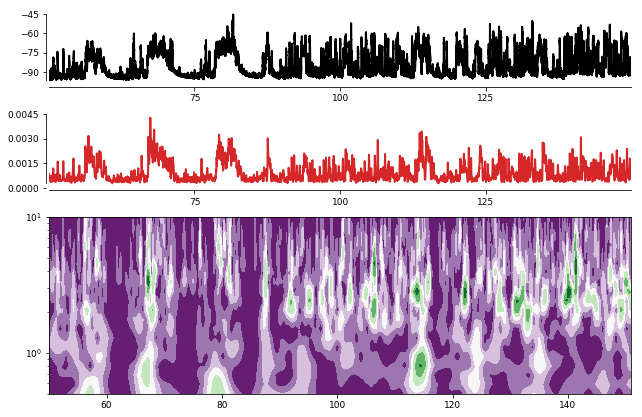

In [535]:
show_Vm_pLFP_spectrogram(data_awake)

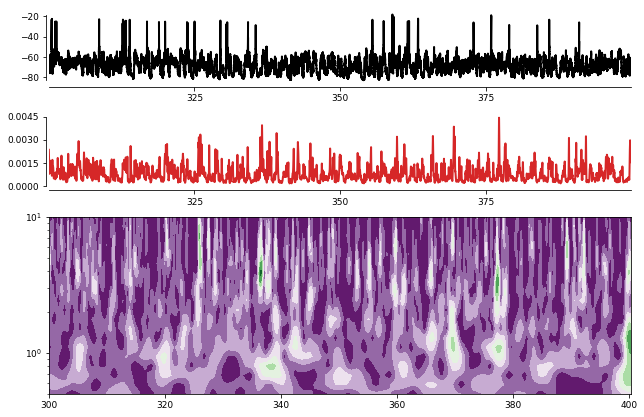

In [536]:
show_Vm_pLFP_spectrogram(data_anesth)

## Finding the level of ~quiescent activity

Idea: we look for the strongly oscillating samples and we take the
level found in the down phase of those

In [537]:
from graphs.my_graph import *
from scipy.integrate import cumtrapz

def compute_threshold_for_highly_oscill_act(data, threshold=0.95):
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 1000, normed=True)
    return bins[1:][np.argmin((cumtrapz(hist, bins[1:])-threshold)**2)]

def plot_histogram_of_low_freq_power(data, threshold=0.99):
    CUMPROD, BINS = [], []
    for i in range(len(data['low_freqs'])):
        hist, bins = np.histogram(np.abs(data['W_low_freqs'][i,:]), 100, normed=True)
        CUMPROD.append(cumtrapz(hist, bins[1:]))
        BINS.append(bins[2:])
    # plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1, bar_legend_args={}, bar_label='freq')
    plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1)
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 10000, normed=True)
    plot(bins[2:], cumtrapz(hist, bins[1:]), ax=plt.gca(), color='k', lw=3)
    thresh = compute_threshold_for_highly_oscill_act(data, threshold=threshold)
    plt.plot([0, thresh, thresh], [threshold, threshold, 0], 'k--')

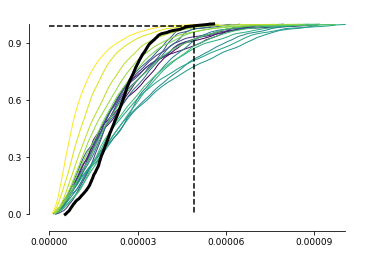

In [538]:
plot_histogram_of_low_freq_power(data_awake)

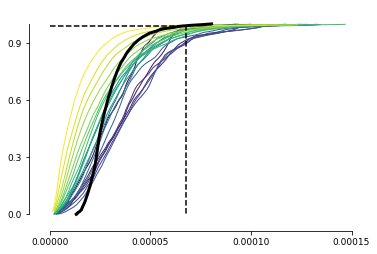

In [539]:
plot_histogram_of_low_freq_power(data_anesth)

(<matplotlib.figure.Figure at 0x1ab09a7518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a979a1908>)

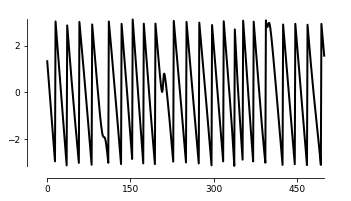

In [540]:
# note we smooth the phase
# plot(np.angle(data_anesth['W_low_freqs'][12,:])[:500], fig_args={'A0_ratio':[.8,.3]})
plot(np.angle(data_anesth['W_low_freqs'][19,:])[:500], fig_args={'A0_ratio':[.8,.3]})


In [541]:
def find_times_of_low_phase(data, power_threshold=0.99, phase_extent=np.pi/12):

    pow_thresh = compute_threshold_for_highly_oscill_act(data, threshold=power_threshold)
    times, indices = [], []
    for i in range(len(data['new_t'])):
        # find freq of max power
        i0 = np.argmax(np.abs(data['W_low_freqs'][:,i]))
        # if np.abs(np.angle(data['W_low_freqs'][i0,i]))>np.pi/2.:
        cond = (np.abs(np.angle(data['W_low_freqs'][i0,i]))>np.pi-phase_extent) and\
            (np.abs(data['W_low_freqs'][i0,i])>pow_thresh)
        if cond:
            indices.append(i)
            times.append(data['new_t'][i])
    data['ind_low_phase'] = indices
    data['times_low_phase'] = times

find_times_of_low_phase(data_anesth)
find_times_of_low_phase(data_awake)

In [542]:
def comparison_plot(data):
    figure()
    plt.bar([0], np.mean(data['pLFP']), yerr=np.std(data['pLFP']), color='grey')
    plt.bar([1], np.mean(data['pLFP'][data['ind_low_phase']]),\
            yerr=np.std(data['pLFP'][data['ind_low_phase']]), color=Red)

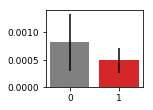

In [559]:
find_times_of_low_phase(data_anesth, phase_extent=np.pi/100., power_threshold=0.99)
comparison_plot(data_anesth)

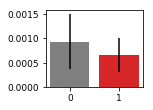

In [558]:
find_times_of_low_phase(data_awake, phase_extent=np.pi/1000., power_threshold=0.9999)
comparison_plot(data_awake)

In [554]:
def see_low_times_of_low_phase_with_Vm(data, zoom=[-np.inf, np.inf]):
    ax = figure(A0_ratio=(1,.3))[1][0][0]
    cond = (data['t']>zoom[0]) & (data['t']<zoom[1])
    plot(data['t'][cond][::10], data['Vm'][cond][::10], lw=1, ax=ax)
    cond = (data['new_t'][data['ind_low_phase']]>zoom[0]) & (data['new_t'][data['ind_low_phase']]<zoom[1])
    scatter(data['new_t'][data['ind_low_phase']][cond],\
            -80.*np.ones(len(np.array(data['ind_low_phase'])[cond])), color=Red, ax=ax)

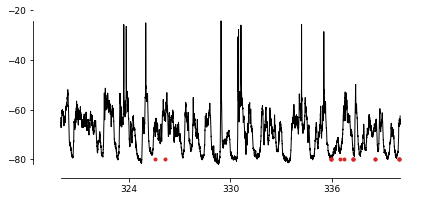

In [555]:
see_low_times_of_low_phase_with_Vm(data_anesth, zoom=[320, 340])

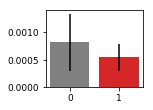

In [458]:
find_times_of_low_phase(data_anesth)
comparison_plot(data_anesth)

In [252]:
power_bins = np.digitize(np.abs(W).mean(axis=0), 100)

(<matplotlib.figure.Figure at 0x1a9a916080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a10b45710>)

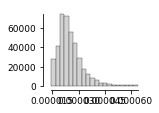

In [247]:
hist(np.abs(W).mean(axis=0))

In [206]:
freqs

array([  0.1       ,   0.1274275 ,   0.16237767,   0.20691381,
         0.26366509,   0.33598183,   0.42813324,   0.54555948,
         0.6951928 ,   0.88586679,   1.12883789,   1.43844989,
         1.83298071,   2.33572147,   2.97635144,   3.79269019,
         4.83293024,   6.15848211,   7.8475997 ,  10.        ])

(<matplotlib.figure.Figure at 0x1a119f3e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a9d280dd8>)

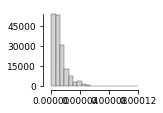

In [204]:
hist(np.abs(W[-1,:]))

(<matplotlib.figure.Figure at 0x1a1047fa90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1042b898>)

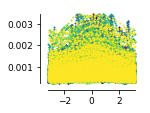

In [200]:
scatter(X=np.angle(W), Y=[data_awake['hGamma_Act'] for i in range(len(W))], ms=1)
